# Homework 1

## Instructions

First, ensure you have cloned the [course repository](https://github.com/lydiaYchen/DDL25Spring).

Then, open the [interactive notebook version](https://github.com/lydiaYchen/DDL25Spring/blob/main/lab/homework-1.ipynb) of this homework from your local copy.

For part A, fill in the code and answers within the notebook and save your changes.

For part B, create and archive the necessary Python/shell scripts together.

Finally, upload the notebook and the archive to the assignment in ILIAS.

## Part A (12 points)

### Note

When not otherwise specified, use the following parameter values in experiment runs:
- `nr_clients` (N): 100
- `lr`: 0.01
- `client_fraction` (C): 0.1
- `nr_local_epochs` (E): 1
- `batch_size` (B): 100
- `nr_rounds`: 10
- `iid`: True

For all exercises, pass `seed = 10` to calls for splitting data, server initialization, or plotting.

In [2]:
import pandas as pd
import seaborn as sns
from tutorial_1a.hfl_complete import *

n = 100
lr = 0.01
c = 0.1
e = 1
b = 100
nr_rounds = 10
iid = True
seed = 10

### Exercise A1: FedSGD with weights (3 points)

#### Question

_(2 points)_ Implement a version of FedSGD that uses weights in its updates, like FedAvg, instead of the gradients from the version of the tutorials. The two FedSGD versions should have the same test accuracy after each round (with a tolerance of at most 0.02%). To show this, compare their output for the following two scenarios over *5 rounds*:
- `lr = 0.01, client_subsets = split(100, True, ...), client_fraction = 0.5`
- `lr = 0.1, client_subsets = split(50, False, ...), client_fraction = 0.2`

*Tip:* You can use the existing FedAvg implementation to minimize the amount of code writing required.

_(1 point)_ Explain in which cases (about the different parameters for decentralized learning) the two are equivalent.

#### Answer

In [ ]:
class FedAvgServer(DecentralizedServer):
    def __init__(
            self, lr: float, batch_size: int, client_subsets: list[Subset],
            client_fraction: float, nr_local_epochs: int, seed: int) -> None:
        super().__init__(lr, batch_size, client_subsets, client_fraction, seed)
        self.name = "FedAvg"
        self.nr_local_epochs = nr_local_epochs
        self.clients = [
            WeightClient(subset, lr, batch_size, nr_local_epochs)
            for subset in client_subsets]

    def run(self, nr_rounds: int) -> RunResult:
        elapsed_time = 0.
        run_result = RunResult(
            self.name, self.nr_clients, self.client_fraction, self.batch_size,
            self.nr_local_epochs, self.lr, self.seed)

        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(
                self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i] for i in indices_chosen_clients) #total nb of samples from clients, bc clients data not same amount
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.

            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_weights = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_weights.append([
                    self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                     for tens in client_weights])
                update_time = max(update_time, perf_counter() - update_start_time)

            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            averaged_chosen_weights: list[torch.Tensor] = [
                torch.stack(x, dim=0).sum(dim=0) for x in zip(*chosen_adjusted_weights)]

            with torch.no_grad():
                zip_weight_parameter = zip(averaged_chosen_weights, self.model.parameters())
                for client_weight, server_parameter in zip_weight_parameter:
                    server_parameter[:] = client_weight.to(device=device)
                    #no optimizer since we have weights

            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        return run_result

In [5]:
sample_split = split(100, True, 42)

In [6]:
fedavg_server = FedAvgServer(0.02, 200, sample_split, 0.2, 2, 42)
result_fedavg = fedavg_server.run(5)
fedavg_df = result_fedavg.as_df()
fedavg_df

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.2,200,2,0.02,42,40,20.95
1,2,FedAvg,100,0.2,200,2,0.02,42,80,54.43
2,3,FedAvg,100,0.2,200,2,0.02,42,120,67.55
3,4,FedAvg,100,0.2,200,2,0.02,42,160,75.07
4,5,FedAvg,100,0.2,200,2,0.02,42,200,77.23


In [7]:
class FedSGDServer(DecentralizedServer):
    def __init__(
            self, lr: float, batch_size: int, client_subsets: list[Subset],
            client_fraction: float, seed: int) -> None:
        super().__init__(lr, batch_size, client_subsets, client_fraction, seed)
        self.name = "FedSGD"
        self.clients = [
            WeightClient(subset, lr, batch_size, 1)  # Only 1 local epoch for FedSGD
            for subset in client_subsets]

    def run(self, nr_rounds: int) -> RunResult:
        elapsed_time = 0.
        run_result = RunResult(
            self.name, self.nr_clients, self.client_fraction, self.batch_size,
            1, self.lr, self.seed)  # Only 1 local epoch for FedSGD

        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(
                self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i] for i in indices_chosen_clients)
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.

            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_weights = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_weights.append([
                    self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                     for tens in client_weights])
                update_time = max(update_time, perf_counter() - update_start_time)

            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            averaged_chosen_weights: list[torch.Tensor] = [
                torch.stack(x, dim=0).sum(dim=0) for x in zip(*chosen_adjusted_weights)]

            with torch.no_grad():
                zip_weight_parameter = zip(averaged_chosen_weights, self.model.parameters())
                for client_weight, server_parameter in zip_weight_parameter:
                    server_parameter[:] = client_weight.to(device=device)

            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        return run_result

<Axes: xlabel='Round', ylabel='Test Accuracy'>

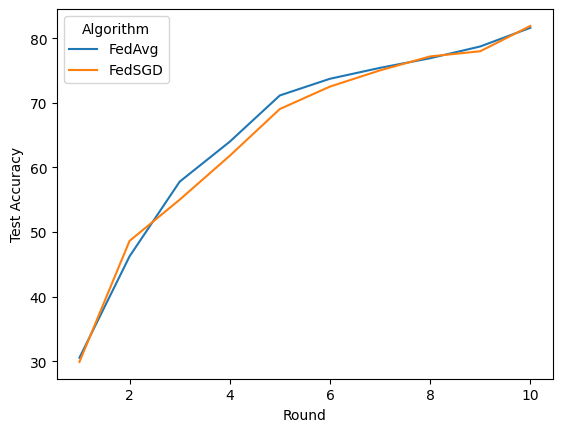

In [9]:
# Parameters
n = 100
lr = 0.01
c = 0.1
e = 1
b = 100
nr_rounds = 10
iid = True
seed = 10

# Split data
client_subsets = split(n, iid, seed)

# Initialize servers
fed_avg_server = FedAvgServer(lr, b, client_subsets, c, e, seed)
fed_sgd_server = FedSGDServer(lr, b, client_subsets, c, seed)

# Run servers
result_avg = fed_avg_server.run(nr_rounds)
result_sgd = fed_sgd_server.run(nr_rounds)

# Collect results
results = {
    "FedAvg": result_avg.test_accuracy,
    "FedSGD": result_sgd.test_accuracy
}

# Create DataFrame for plotting
df = pd.DataFrame(results)
df["Round"] = range(1, nr_rounds + 1)
df = df.melt(id_vars=["Round"], var_name="Algorithm", value_name="Test Accuracy")

# Plot results
sns.lineplot(data=df, x="Round", y="Test Accuracy", hue="Algorithm")

In [11]:
# Parameters
n = 100
lr = 0.01
c = 0.1
e = 1
b = 100
nr_rounds = 5
iid = True
seed = 10

# Split data
client_subsets = split(n, iid, seed)

# Initialize servers
fed_avg_server = FedAvgServer(lr, b, client_subsets, c, e, seed)
fed_sgd_server = FedSGDServer(lr, b, client_subsets, c, seed)

# Run servers
result_fedavg = fed_avg_server.run(nr_rounds)
result_fedsgd = fed_sgd_server.run(nr_rounds)

# Convert results to DataFrames
fedavg_df = result_fedavg.as_df()
fedsgd_df = result_fedsgd.as_df()

# Display DataFrames
print("FedAvg Results:")
print(fedavg_df)

print("\nFedSGD Results:")
print(fedsgd_df)

FedAvg Results:
   Round Algorithm    N    C    B  E     η  Seed  Message count  Test accuracy
0      1    FedAvg  100  0.1  100  1  0.01    10             20          30.55
1      2    FedAvg  100  0.1  100  1  0.01    10             40          46.24
2      3    FedAvg  100  0.1  100  1  0.01    10             60          57.80
3      4    FedAvg  100  0.1  100  1  0.01    10             80          63.99
4      5    FedAvg  100  0.1  100  1  0.01    10            100          71.15

FedSGD Results:
   Round Algorithm    N    C    B  E     η  Seed  Message count  Test accuracy
0      1    FedSGD  100  0.1  100  1  0.01    10             20          31.28
1      2    FedSGD  100  0.1  100  1  0.01    10             40          46.20
2      3    FedSGD  100  0.1  100  1  0.01    10             60          57.42
3      4    FedSGD  100  0.1  100  1  0.01    10             80          64.61
4      5    FedSGD  100  0.1  100  1  0.01    10            100          70.12


In [ ]:
class WeightClient(Client):
    def __init__(self, client_data: Subset, lr: float, batch_size: int, nr_epochs: int) -> None:
        super().__init__(client_data, batch_size)
        self.optimizer = SGD(params=self.model.parameters(), lr=lr)
        self.nr_epochs = nr_epochs


    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values

        self.generator.manual_seed(seed)

        for _epoch in range(self.nr_epochs): #train for a number of epochs (multiples this time)
            train_epoch(self.model, self.loader_train, self.optimizer)

        return [x.detach().cpu().clone() for x in self.model.parameters()]


class FedAvgServer(DecentralizedServer):
    def __init__(
            self, lr: float, batch_size: int, client_subsets: list[Subset],
            client_fraction: float, nr_local_epochs: int, seed: int) -> None:
        super().__init__(lr, batch_size, client_subsets, client_fraction, seed)
        self.name = "FedAvg"
        self.nr_local_epochs = nr_local_epochs
        self.clients = [
            WeightClient(subset, lr, batch_size, nr_local_epochs)
            for subset in client_subsets]

    def run(self, nr_rounds: int) -> RunResult:
        elapsed_time = 0.
        run_result = RunResult(
            self.name, self.nr_clients, self.client_fraction, self.batch_size,
            self.nr_local_epochs, self.lr, self.seed)

        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(
                self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i] for i in indices_chosen_clients) #total nb of samples from clients, bc clients data not same amount
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.

            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_weights = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_weights.append([
                    self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                     for tens in client_weights])
                update_time = max(update_time, perf_counter() - update_start_time)

            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            averaged_chosen_weights: list[torch.Tensor] = [
                torch.stack(x, dim=0).sum(dim=0) for x in zip(*chosen_adjusted_weights)]

            with torch.no_grad():
                zip_weight_parameter = zip(averaged_chosen_weights, self.model.parameters())
                for client_weight, server_parameter in zip_weight_parameter:
                    server_parameter[:] = client_weight.to(device=device)
                    #no optimizer since we have weights

            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        return run_result

TODO

### Exercise A2: Client number & fraction (4 points)

#### Question

_(2 points)_ Run the necessary experiments to fill in the following table showing the final message count and test accuracy of FedSGD and FedAvg for different total client numbers:

| Algorithm | N   | C   | Message count | Test accuracy |
| --------- | --- | --- | ------------- | ------------- |
| FedSGD    | 10  | 0.1 |               |               |
| FedAvg    | 10  | 0.1 |               |               |
| FedSGD    | 50  | 0.1 |               |               |
| FedAvg    | 50  | 0.1 |               |               |
| FedSGD    | 100 | 0.1 |               |               |
| FedAvg    | 100 | 0.1 |               |               |

Is the relationship between the metrics and client numbers monotonous?

_(2 points)_ Run the experiments to fill in the table when varying the fraction of clients used in every round:

| Algorithm | N   | C    | Message count | Test accuracy |
| --------- | --- | ---- | ------------- | ------------- |
| FedSGD    | 100 | 0.01 |               |               |
| FedAvg    | 100 | 0.01 |               |               |
| FedSGD    | 100 | 0.1  |               |               |
| FedAvg    | 100 | 0.1  |               |               |
| FedSGD    | 100 | 0.2  |               |               |
| FedAvg    | 100 | 0.2  |               |               |

How does the observed pattern differ?

#### Answer

In [ ]:
# TODO

TODO

In [ ]:
# TODO

TODO

### Exercise A3: Local epoch count & (non-)IID data (5 points)

no IID -> be careful with params

#### Question

_(1 point)_ Create a line plot of the accuracy after each round for the following algorithm variants:

- FedSGD
- FedAvg (E=1)
- FedAvg (E=2)
- FedAvg (E=4)

How does FedAvg compare to FedSGD? What is the effect of increasing the work clients perform locally for each update in FedAvg?

_(2 points)_ Make one line plot of FedSGD and FedAvg under an IID and non-IID split for 15 rounds (leaving all other parameter values as they previously mentioned default). How does the non-IID setting affect the accuracy achieved by the two algorithms? What is the difference in terms of the smoothness of learning?

_(2 points)_ Make another plot for only non-IID splits, including the FedSGD and FedAvg configs from before, and add a version for each with a learning rate of 0.001 and client fraction of 0.5. How does the stability of the new variants compare to the old ones? Why do the changes in parameters have the observed effect?

#### Answer

In [ ]:
# TODO

TODO

In [ ]:
# TODO

TODO

In [ ]:
# TODO

TODO

## Part B (12 points)

### Exercise B1: Microbatch Pipeline Model Parallelism (7 points)

Implement pipeline parallelism with microbatches, as discussed during the lab.

As with the other data/model parallelism examples, you will need a Python script for the nodes and a shell script to orchestrate execution.

Be aware of the possibility of deadlocks: due to how `good` operates, it is possible to deadlock by having device 1 send $B_2$ to device 2 in the forward pass, and simultaneously, device 2 send $B_1$ in the backward pass.
Since both operations will await a corresponding receive the training will stop indefinitely.

Use `isend` & `irecv`, the asynchronous (non-blocking) versions of `send` & `recv` in `torch.distributed`.
Add comments or text explaining how you expect your implementation to work and test that it runs for the same number of steps and model architecture as in class.

Note that `torch.distributed`'s implementation of `gloo` does not currently support properly asynchronous communication even when using the corresponding primitives.
Thus, you will not see the same improvements in speed as with a backend like `nccl`.

You may also take advantage of the fact that `torch` gradients naturally accumulate if zeroed out.
Also, scaling the loss by a constant is equivalent to scaling the resulting gradients by the same constant.

### Exercise B2: Joint Data & Model Parallelism (5 points)

Implement a training setup that uses data and model parallelism together.

Create 2 pipelines of 3 stages running sequentially, where each stage works with 3 sequential micro-batches.

Once again, add comments or text explaining your implementation and test it on the setting that mimics those from the class.

You can use groups from `torch.distributed` to handle operations that require interaction between a subset of more than two but less than all workers.